### Cab-Driver Agent

In [5]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

import os

# for dataframe of optimal Q-values
import pandas as pd
pd.set_option('display.max_columns', None)

# for suppressing the warning
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


#### Defining Time Matrix

In [6]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [7]:
# Initialise States_tracked as 'States_track' (for convergence)
States_track = collections.defaultdict(dict)

# Defining a function to initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [
        ((0,0,0),(0, 1)),
        ((0,1,0),(1, 0)),
        ((0,0,1),(1, 2))] 
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

initialise_tracking_states()
States_track

defaultdict(dict,
            {(0, 0, 0): {(0, 1): []},
             (0, 0, 1): {(1, 2): []},
             (0, 1, 0): {(1, 0): []}})

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        
        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.80
        self.learning_rate = 0.0001
        self.epsilon_max = 1
        self.epsilon_decay = -0.0004
        self.epsilon_min = 0
        
        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # create main model and target model
        self.model = self.build_model()
        
        # Call the environment
        env = CabDriver()
        
        
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model


    def get_action(self, state, time):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay*time)
        possible_actions_index = env.requests(state)[0]
        if np.random.rand() <= epsilon:
            action_idx = np.random.choice(possible_actions_index)
            return action_idx
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, state_size)
            q_values = self.model.predict(state)
            # extracting relevant q_values for possible actions
            relevant_q_values = {possible_actions_index[i]:q_values[0][possible_actions_index[i]] 
                                 for i in range(len(possible_actions_index))}
            action_idx = max(relevant_q_values,key=relevant_q_values.get)
            return action_idx


    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state)) # it will append state, action, reward, next_state in memory as quadruple

    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # Initialise the variables update_input and update_target for a batch for storing the s and s'.
            # Later, we will use it to store Q_t(S_t,a_t) and Q_t(S_{t+1},a)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state= mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state

            # Write your code from here
            # 1. Predict the target from earlier model
            # storing Q_t(S_t,a_t) in target
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            # storing Q_t(S_{t+1},a) in target_val
            target_val = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                    # If cab-driver crosses 24*30 hours but he has already started the trip then he’ll finish that trip and
                    # then stop for recharging so future reward of next state will also add
                    # Q Learning: get maximum Q value at s' from target model
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    # To save the model weights
    def save(self, name):
        self.model.save(name)
    
    
    # Defining a function for saving states track
    def save_tracking_states(self):
        for state in States_track.keys():
            state_vec = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
            q_values = self.model.predict(state_vec)
            for action in States_track[state].keys():
                States_track[state][action].append(q_values[0][env.action_space.index(action)])

In [10]:
n_episodes = 20000 # number of episodes
rewards_per_episode = [] # to store rewards in each episode

# Call the environment
env = CabDriver() #creating an instance of the class

#Call the DQN agent
state_size = len(env.state_encod_arch1(env.state_space))
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)

# initializing the variables to store qvalues for each state and action
Qvalues = np.zeros((len(env.state_space), len(env.action_space)))

### DQN block

In [11]:
start_time = time.time()

for episode in range(n_episodes):

    # Write code here
    # Call all the initialised variables of the environment
    action_space, state_space, state_init = env.reset()    # Reset the environment
    curr_state = state_init # Initial state is current state at start of the episode
    terminal_state = False       # 'terminal' defines terminal state
    score = 0       # total rewards zero at start of the episode
    total_time = 0  # total time-spent zero at start of the episode
    
    biggest_change = 0 # to track convergence 
    timestep = 0 # to set minimum timesteps for checking convergence and storing qvalues
    
    while not terminal_state:
        # Write your code here
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        curr_action_idx = agent.get_action(curr_state, episode)
        
        # 2. Evaluate your reward and next state
        next_state, reward, total_time_spent = env.step(curr_state, curr_action_idx, Time_matrix)
        total_time += total_time_spent
        # terminal_state will True once cab-driver crosses 24*30 hours.
        terminal_state = True if total_time > 24*30 else False
        
        # 3. Append the experience to the memory
        # convert curr_state and next state into a vector so that it can be fed to the NN using append_sample
        curr_state_vec = env.state_encod_arch1(curr_state)
        next_state_vec = env.state_encod_arch1(next_state)
        agent.append_sample(curr_state_vec, curr_action_idx, reward, next_state_vec)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        # 5. Keep a track of rewards, Q-values
        # rewards
        score += reward
        
        timestep = timestep + 1
        if timestep > 32: # once training start, it will track convergence and store Q-values
            # reshape curr_state_vec to directly fed to NN
            curr_state_vec_reshape = np.array(curr_state_vec).reshape(1, state_size)
            # predicting qvalue for current state
            qval = agent.model.predict(curr_state_vec_reshape) 
            # finding state number
            state_number = env.state_space.index(curr_state)
            # To track convergence finding biggest change between qvalues 
            biggest_change = max(biggest_change, abs(qval[0][curr_action_idx] - Qvalues[state_number][curr_action_idx]))
            # For storing Q-values for each state and action
            Qvalues[state_number][curr_action_idx] = qval[0][curr_action_idx]
        
        curr_state = next_state
    
    # storing total reward obtained in this episode
    rewards_per_episode.append(score)
    # storing q_values for states tracked
    agent.save_tracking_states()
    
    if (episode+1) % 10 == 0:
        # saving model weights
        agent.save(name="model_weights.h5")
    
    if (episode+1) % 1000 == 0:
        # saving rewards_per_episode after every 1000 episode
        save_obj(rewards_per_episode,'rewards_per_episode')
        # saving states tracked after every 1000 episode
        save_obj(States_track,'states_tracked')
        # print episode, reward, memory length and epsilon-decay for every 1000th episode
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, biggest_change {4}".format
              (episode+1, 
               score, 
               len(agent.memory), 
               (agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay*episode)), 
               biggest_change))
        # After every 1000 episode, checking if biggest change between qvalues is less than 0.00000001
        small_change = 0.00000001
        if biggest_change < small_change:
            break # if biggest change between in qvalues is less than 0.00000001 then stop the training
    

end = time.time()    
elapsed_time = time.time() - start_time
print("Time taken in seconds: ", elapsed_time)

episode 1000, reward 607.0, memory_length 2000, epsilon 0.670588227686808, biggest_change 21.27081298828125
episode 2000, reward 797.0, memory_length 2000, epsilon 0.44950873165397887, biggest_change 26.13909912109375
episode 3000, reward 1239.0, memory_length 2000, epsilon 0.301314713695717, biggest_change 16.49859619140625
episode 4000, reward 1211.0, memory_length 2000, epsilon 0.20197729275572845, biggest_change 21.08708953857422
episode 5000, reward 1779.0, memory_length 2000, epsilon 0.1353894281781737, biggest_change 5.119377136230469
episode 6000, reward 1776.0, memory_length 2000, epsilon 0.09075424772913229, biggest_change 8.455696105957031
episode 7000, reward 1721.0, memory_length 2000, epsilon 0.06083439151572175, biggest_change 5.3604736328125
episode 8000, reward 2007.0, memory_length 2000, epsilon 0.04077851212136871, biggest_change 8.341567993164062
episode 9000, reward 2069.0, memory_length 2000, epsilon 0.027334654122460753, biggest_change 5.9840545654296875
episode 

### Tracking Convergence

In [12]:
# loading rewards_per_episode.pkl to plot the rewards
with open('rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

Text(0, 0.5, 'Reward Per Episode')

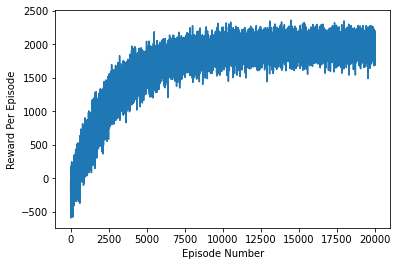

In [13]:
# plotting rewards per episode
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("Episode Number")
plt.ylabel("Reward Per Episode")

In [14]:
# loading states_tracked.pkl to plot the qvalues for state-action pairs tracked
with open('states_tracked.pkl', 'rb') as f:
    States_track = pickle.load(f)  

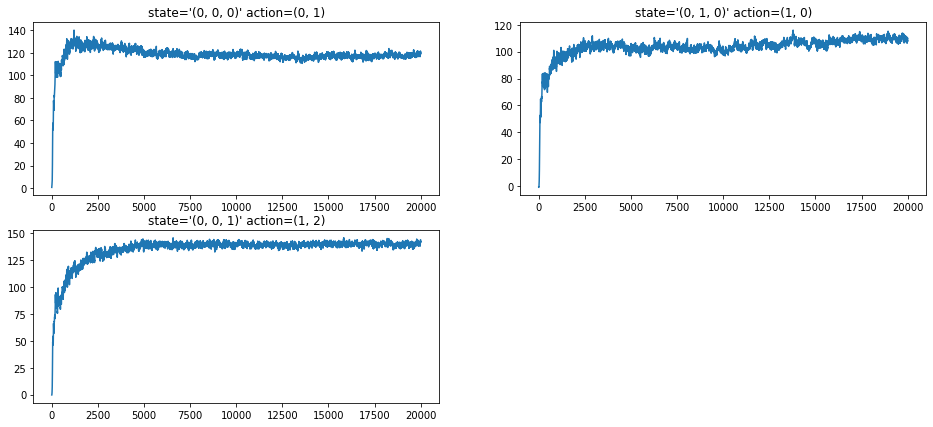

In [15]:
# Q-values vs Episodes for (state,action) pair. Episodes where (state,action)pair appeared
plt.figure(0, figsize=(16,7))
plt.subplot(221)
plt.title("state='(0, 0, 0)' action=(0, 1)")
plt.plot(np.asarray(range(0, len(States_track[(0, 0, 0)][(0, 1)]))),np.asarray(States_track[(0, 0, 0)][(0, 1)]))
plt.subplot(222)
plt.title("state='(0, 1, 0)' action=(1, 0)")
plt.plot(np.asarray(range(0, len(States_track[(0, 1, 0)][(1, 0)]))),np.asarray(States_track[(0, 1, 0)][(1, 0)]))
plt.subplot(223)
plt.title("state='(0, 0, 1)' action=(1, 2)")
plt.plot(np.asarray(range(0, len(States_track[(0, 0, 1)][(1, 2)]))),np.asarray(States_track[(0, 0, 1)][(1, 2)]))
plt.show()

#### Optimal Q values

In [16]:
# optimal qvalues
Qvalues_df = pd.DataFrame(data=Qvalues, index=env.state_space, columns=env.action_space)
Qvalues_df.head(10)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(1, 0)","(1, 2)","(1, 3)","(1, 4)","(2, 0)","(2, 1)","(2, 3)","(2, 4)","(3, 0)","(3, 1)","(3, 2)","(3, 4)","(4, 0)","(4, 1)","(4, 2)","(4, 3)"
"(0, 0, 0)",125.717216,116.402977,132.956192,156.259964,126.866051,106.383507,129.972931,119.521820,109.233406,104.117264,137.731140,133.388092,103.915916,105.853622,95.934212,103.209915,98.230255,108.837517,132.258438,119.070801,123.778214
"(0, 0, 1)",117.697350,136.982193,148.496338,149.452255,126.745750,118.710098,142.428162,132.865311,110.952606,102.666153,127.295395,110.287727,95.744102,90.031868,97.219849,114.410904,95.954895,118.211067,114.900162,118.135445,134.691406
"(0, 0, 2)",123.142242,130.017914,138.220657,151.526917,129.962997,121.168678,121.554916,122.835571,121.116898,109.934883,120.310219,122.277962,101.275528,121.284477,101.410461,93.807571,99.306358,97.196228,128.289780,113.782738,122.782196
"(0, 0, 3)",114.917603,141.659424,138.847351,134.086929,127.840630,125.814369,139.778778,117.312134,114.837502,104.589668,134.811493,112.406021,101.252960,106.985535,95.421616,100.930939,104.617538,108.122353,123.529427,132.945038,120.855461
"(0, 0, 4)",119.404327,157.963364,142.572662,151.353378,131.982452,127.087708,119.078957,123.145348,112.046814,112.739166,136.649841,129.212906,116.180511,103.460838,99.828506,120.716591,97.034531,104.672531,128.541290,131.128815,136.533646
"(0, 0, 5)",126.400124,135.868668,159.971420,133.301819,129.329880,135.491379,162.853317,122.376167,105.797379,104.249580,128.834503,117.790314,90.438370,107.813324,106.751709,142.184326,110.228432,105.023407,126.796501,137.493683,129.985519
"(0, 0, 6)",115.133720,144.037125,144.421158,148.874786,125.316422,116.947968,118.052170,118.074577,116.263054,99.981071,116.899689,106.039337,71.027153,116.007317,103.448067,121.187172,92.930656,104.379562,115.834747,104.193420,124.278961
"(0, 1, 0)",124.615326,126.645752,135.433685,166.080353,125.128601,100.564468,136.117645,109.012566,110.867226,112.073380,144.257355,130.976456,97.853043,105.273476,99.969070,108.880203,106.407097,113.854874,136.481796,122.350914,132.164749
"(0, 1, 1)",117.488411,139.167938,146.908279,151.414780,124.949120,118.810913,142.268021,129.486176,110.345390,102.641777,132.134201,110.094574,96.526794,94.429642,100.440178,102.538742,101.695091,116.158379,121.656830,116.773186,139.251678
"(0, 1, 2)",122.938499,135.715256,137.703903,156.290176,127.137726,122.126511,122.459862,121.496460,120.822800,109.159988,121.441818,122.771317,102.159103,121.244736,99.409431,93.221138,93.658646,110.380836,135.665268,113.253174,123.644272


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [17]:
time = np.arange(0,20000)
epsilon = []
for i in range(0,20000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0004*i))

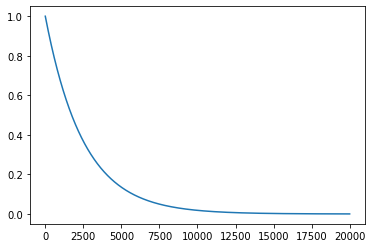

In [18]:
plt.plot(time, epsilon)
plt.show()